In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def pre_process_imgs(img):
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    return img

In [4]:
MNIST_dataset = tf.data.Dataset.from_tensor_slices(x_train)
MNIST_dataset = MNIST_dataset.map(pre_process_imgs).batch(128)

In [5]:
from warnings import filters


class MnistEncoder(tf.keras.layers.Layer):
    def __init__(self, filters, latent_dim):
        super(MnistEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=3, strides=1, padding='same', activation='tanh')
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.conv2 = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=3, strides=1, padding='same', activation='tanh')
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.conv3 = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=3, strides=1, padding='same', activation='tanh')
        self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense_mu = tf.keras.layers.Dense(self.latent_dim, activation=None)
        self.dense_logsig2 = tf.keras.layers.Dense(self.latent_dim, activation=None)

    def call(self, x):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        mu = self.dense_mu(x)
        logsig2 = self.dense_logsig2(x)
        return mu, tf.exp(logsig2)


In [6]:
class MnistDecoder(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, output_dim):
        super(MnistDecoder, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [7]:
class MnistVAE(tf.keras.Model):
    def __init__(self, filters, hidden_dim, latent_dim, output_dim):
        super(MnistVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = MnistEncoder(filters, latent_dim)
        self.decoder = MnistDecoder(hidden_dim, output_dim)

    def encode(self, x):
        mu, sig2 = self.encoder(x)
        return mu, sig2

    def sample_latent(self, mu, sig2):
        z = tf.random.normal(shape=mu.shape)
        return z * tf.sqrt(sig2) + mu

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mu, sig2 = self.encode(x)
        z = self.sample_latent(mu, sig2)
        return self.decode(z)

    def elbo_loss(self, x, z, p, mu, sig2):
        """calculates ELBO loss

        Args:
            x : input iamges
            z : samples from latent space
            p : output from decoder
            mu : learned means
            sig2 : learned variances
        """

        # log_q(z|x) logprobability of z under approximate posterior N(mu, sig)
        log_q = tfp.distributions.Normal(loc=mu, scale=tf.sqrt(sig2)).log_prob(z)
        log_q = tf.reduce_sum(log_q, axis=1)

        # log_p_z(z) log probability of z under prior
        log_p_z = tfp.distributions.Normal(loc=tf.constant(0., shape=(x.shape[0], self.latent_dim)), scale=tf.constant(1., shape=(x.shape[0], self.latent_dim))).log_prob(z)
        log_p_z = tf.reduce_sum(log_p_z, axis=1)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = tfp.distributions.Bernoulli(probs=p).log_prob(tf.reshape(x, shape=(x.shape[0], -1)))
        log_p = tf.reduce_sum(log_p, axis=1)
        
        # log_p_z(z) + log_p(x|z) - log_q(z|x)
        return tf.reduce_mean(log_p_z + log_p - log_q)


    def train_step(self, x, optimizer):
        with tf.GradientTape() as tape:
            mu, sig2 = self.encode(x)
            z = self.sample_latent(mu, sig2)
            p = self.decode(z)
            loss = -1 * self.elbo_loss(x, z, p, mu, sig2)
        grads = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss

    def train(self, dataset, epochs):
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        for epoch in range(epochs):
            for batch in dataset:
                loss = self.train_step(batch, optimizer)
            print("Epoch: {}, Loss: {}".format(epoch, loss))

    def visualize_data_space(self, img):
        mu, sigma_square = self.encoder(img)
        # TODO: Sample 10 z from prior 
        z = self.sample_latent(mu, sigma_square)

        # TODO: For each z, plot p(x|z)
        p = self.decoder(z)
        x_sample = tfp.distributions.Bernoulli(probs=p).sample()

        fig, axs = plt.subplots(1, 2, figsize=(5, 10), dpi=100)

        axs[0].imshow(tf.reshape(p, shape=(28, 28)))
        axs[1].imshow(tf.reshape(x_sample, shape=(28, 28)))
        axs[0].axis('off')
        axs[1].axis('off')
        plt.tight_layout()
        plt.show()

    def visualize_latent_space(self, dataset, labels):
        
        # TODO: Encode the training data self.train_images
        mu, _ = self.encoder(dataset)
        colors = ['red', 'blue', 'yellow', 'green', 'orange', 'purple', 'cyan', 'magenta', 'black', 'brown']
        fig, ax = plt.subplots(1, 1, figsize = (5, 5), dpi = 100)
        point_sets = []
        for i in range(len(colors)):
            inner_list = []
            for _ in range(mu.shape[1]):
                inner_list.append([])
            point_sets.append(inner_list)

        for i in range(mu.shape[0]):
            label = labels[i]
            point_sets[label][0].append(mu[i, 0])
            point_sets[label][1].append(mu[i, 1])
        
        for i in range(len(point_sets)):
            ax.scatter(point_sets[i][0], point_sets[i][1], color=colors[i], label=i)
        plt.legend()
        ax.set_xlabel(r"$\mu_1$")
        ax.set_ylabel(r"$\mu_2$")
        plt.show()

    def interpolate_mu(self, mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub

    def visualize_inter_class_interpolation(self, imgs, labels):
        N_data = imgs.shape[0]
        fig, axs = plt.subplots(1, 10, figsize=(20, 5), dpi=100)

        id_1 = np.random.randint(0, N_data, (1,))[0]
        sample_1 = imgs[id_1, ...]
        label_1 = labels[id_1]
        while True:
            id_2 = np.random.randint(0, N_data, (1,))[0]
            sample_2 = imgs[id_2, :]
            label_2 = labels[id_2]
            if label_1 != label_2:
                break

        mu1, sigma1 = self.encoder(tf.reshape(sample_1, shape=(1, 28, 28)))
        mu2, sigma2 = self.encoder(tf.reshape(sample_2, shape=(1, 28, 28)))

        for i in range(10):
            z = self.interpolate_mu(mu1, mu2, i*0.1)
            p = self.decoder(z)
            img = tf.reshape(p, shape=(28, 28))
            axs[i].imshow(img)
            axs[i].set_title(r"$\alpha$ = %.1f" % (0.1*i))
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()

    

In [8]:
test = MnistVAE(filters=[64, 256, 512], hidden_dim=1024, latent_dim=2, output_dim=784)

In [9]:
test.train(MNIST_dataset, 200)

Epoch: 0, Loss: 198.2141571044922
Epoch: 1, Loss: 190.51829528808594
Epoch: 2, Loss: 190.26048278808594
Epoch: 3, Loss: 186.3338165283203
Epoch: 4, Loss: 182.3324737548828
Epoch: 5, Loss: 179.7847137451172
Epoch: 6, Loss: 176.457275390625
Epoch: 7, Loss: 174.16847229003906
Epoch: 8, Loss: 171.4991912841797
Epoch: 9, Loss: 170.65040588378906
Epoch: 10, Loss: 168.95791625976562
Epoch: 11, Loss: 168.51351928710938
Epoch: 12, Loss: 167.4862823486328
Epoch: 13, Loss: 165.5391845703125
Epoch: 14, Loss: 165.03282165527344
Epoch: 15, Loss: 164.07485961914062
Epoch: 16, Loss: 162.97479248046875
Epoch: 17, Loss: 162.09031677246094
Epoch: 18, Loss: 162.9320526123047
Epoch: 19, Loss: 162.1335906982422
Epoch: 20, Loss: 160.6643829345703
Epoch: 21, Loss: 159.77261352539062
Epoch: 22, Loss: 159.29275512695312
Epoch: 23, Loss: 158.99510192871094
Epoch: 24, Loss: 161.15655517578125
Epoch: 25, Loss: 158.08377075195312
Epoch: 26, Loss: 157.28065490722656
Epoch: 27, Loss: 157.9495086669922
Epoch: 28, Loss

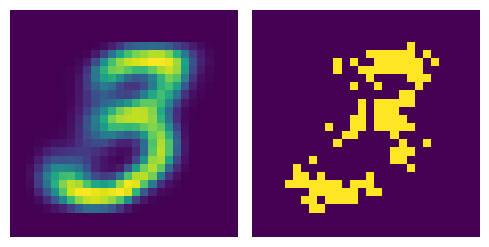

In [10]:
test_img = next(iter(MNIST_dataset))[0]
test_img = tf.reshape(test_img, shape=(1, 28, 28))
test.visualize_data_space(test_img)

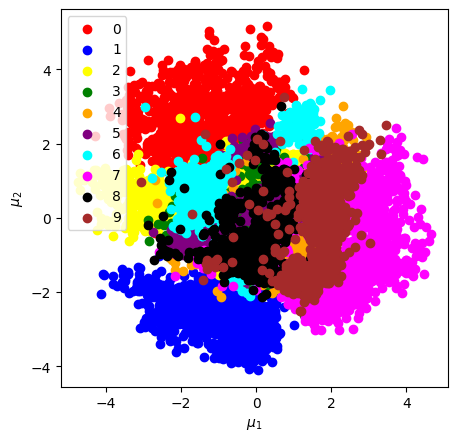

In [11]:
imgs = tf.concat([x for x in MNIST_dataset], axis=0) # get all the data back from the batches
test.visualize_latent_space(imgs[:10000, ...], y_train)

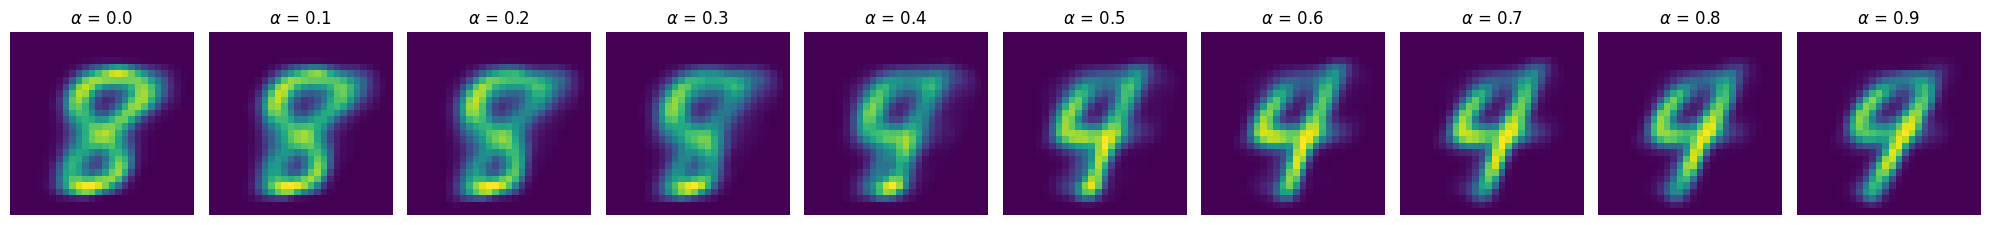

In [12]:
test.visualize_inter_class_interpolation(imgs, y_train)